In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import root

In [2]:
cd C:\Users\LIMDAESUN\Desktop\카이스트관련\신용리스크\CDS_Calibrate

C:\Users\LIMDAESUN\Desktop\카이스트관련\신용리스크\CDS_Calibrate


In [3]:
CDS_Spread = pd.read_excel('CDS_Spread.xlsx', index_col=0)
Discount = pd.read_excel('Discount.xlsx', index_col=0)
DF = pd.concat([pd.DataFrame([np.nan, 1, np.nan], index = Discount.columns).T, Discount], axis = 0)[['Discount']]

In [4]:
def Calculate_CDS_Spread( hazard_rate_array, Discount, dt = 0.5, R = 0.4, Data_result = False) :
    x = hazard_rate_array
    DF = pd.concat([pd.DataFrame([np.nan, 1, np.nan], index = Discount.columns).T, Discount], axis = 0)[['Discount']]
    surv = pd.DataFrame([1], columns = ['Q'])
    spread_lst = []
    for ii, i in enumerate(np.arange(dt, DF.index[-1]+dt, dt)) :
        T = i
        n = T-dt
        Q_before = surv.Q.loc[n]
        lamb_temp = x[ii]
        timeline = np.linspace(0, dt, int(12 * dt)+1).round(2)[1:]
        Q = np.exp(-lamb_temp * timeline) * Q_before
        surv = pd.concat([surv,pd.DataFrame(Q, index = n+ timeline, columns = ['Q'])], axis = 0)
        Data = pd.concat([DF, surv], axis = 1).interpolate(method = 'linear').loc[:T]
        blue = ((np.array(Data.Discount)[:-1] + np.array(Data.Discount)[1:]) *        
                (np.array(Data.Q)[:-1] - np.array(Data.Q)[1:])).sum()
        Z_ = DF.Discount.loc[0:T]
        Q_ = surv.Q.loc[Z_.index]
        RPV01 = 0.5 * dt * (np.array(Z_.loc[0:T].iloc[1:]) * np.array(Q_.loc[0:T])[:-1] + np.array(Q_.loc[0:T])[1:]).sum()
        spread = 0.5 * (1-R) * blue / (RPV01)
        spread_lst.append(spread)
    if Data_result == False :
        return np.array(spread_lst)
    else : 
        return np.array(spread_lst), Data

In [5]:
hr = np.arange(0.02, 0.04,0.001)
Calculate_CDS_Spread( hr, Discount, dt = 0.5, R = 0.4)

array([0.01200028, 0.01226841, 0.01253773, 0.01280505, 0.01307057,
       0.01333361, 0.01359417, 0.0138515 , 0.01410568, 0.01435673,
       0.01460457, 0.01484871, 0.01508915, 0.01532587, 0.01555881,
       0.01578768, 0.01601247, 0.01623315, 0.01644969, 0.01666207])

In [6]:
def CDS_Spread_Interpolate(CDS_Sprad,Discount, dt = 0.5) :    
    CDS_Spread_IP = pd.concat([CDS_Spread, pd.DataFrame([], index = np.arange(dt,CDS_Spread.index[-1]+dt,dt))], axis = 1).interpolate(method = 'linear')
    return CDS_Spread_IP

In [7]:
CDS_Spread_IP = np.array(CDS_Spread_Interpolate(CDS_Spread,Discount).Spread)/10000

In [8]:
def Calibrated_Hazard_Rate(CDS_Spread,Discount,dt,R ) :
    CDS_Spread_IP = np.array(CDS_Spread_Interpolate(CDS_Spread,Discount).Spread)/10000
    def fun(x,Discount, dt, R,P) :
        return  Calculate_CDS_Spread(x,Discount, dt , R) - P
    x0 =np.repeat([0.02],len(CDS_Spread_IP))
    res = root(fun, x0, args = (Discount, dt, R, CDS_Spread_IP))
    return res.x.round(4)

In [9]:
Hazard_Rate = Calibrated_Hazard_Rate(CDS_Spread,Discount,dt= 0.5,R = 0.4) 

In [26]:
CDS_S, Data = Calculate_CDS_Spread(Hazard_Rate, Discount, dt = 0.5, R = 0.4, Data_result= True)
CDS_S

array([0.01200028, 0.01200157, 0.01249544, 0.01299038, 0.01349453,
       0.01400006, 0.01450379, 0.01500324, 0.01550352, 0.01600209,
       0.0157532 , 0.01550217, 0.01525394, 0.01500465, 0.01517167,
       0.01533756, 0.0155048 , 0.01566992, 0.01583766, 0.0160047 ])

In [11]:
CDS_Spread_IP

array([0.012     , 0.012     , 0.0125    , 0.013     , 0.0135    ,
       0.014     , 0.0145    , 0.015     , 0.0155    , 0.016     ,
       0.01575   , 0.0155    , 0.01525   , 0.015     , 0.01516667,
       0.01533333, 0.0155    , 0.01566667, 0.01583333, 0.016     ])

In [31]:
Data.iloc[::12]

,Discount,Q
0.0,1.000000,1.000000
1.0,0.983125,0.980150
2.0,0.968850,0.957289
3.0,0.955359,0.931462
4.0,0.941290,0.902894
5.0,0.927618,0.871752
6.0,0.912920,0.852740
7.0,0.898175,0.835563
8.0,0.882524,0.809410
9.0,0.866653,0.782744


In [12]:
Hazard_Rate

array([0.02  , 0.0201, 0.0227, 0.0245, 0.0264, 0.0283, 0.0302, 0.0321,
       0.0341, 0.0361, 0.0225, 0.0216, 0.0208, 0.0199, 0.0314, 0.0322,
       0.0331, 0.0339, 0.0349, 0.0358])

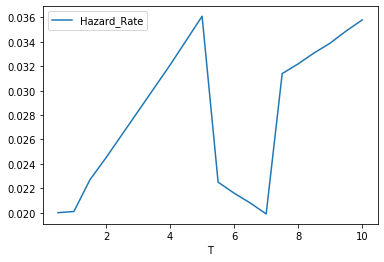

In [24]:
PD = pd.DataFrame(Hazard_Rate, index = CDS_Spread_Interpolate(CDS_Spread,Discount).index, columns = ['Default_Rate'])
plt.plot(PD, label = 'Hazard_Rate')
plt.legend(loc = 'best')
plt.xlabel('T')
plt.show()